In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.sparse.linalg

# install this with "pip install datafold"
import datafold.pcfold as pfold
import datafold.dynfold as dfold

from large_eigensystems import *
from jointly_smooth_functions import JointlySmoothFunctions

import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore',SparseEfficiencyWarning)

In [19]:
# notebook parameters
n_pts = 15000
random_seed = 1
add = 0.2

verbose = True
n_kernel_normalizations = 3
evec_tol = 1e-10

n_kernel_evecs = 500
n_common_evecs = 10

cknn_k_neighbor = 50

cmap1 = "viridis"
cmap2 = "bwr"
m_s = 5

idx_plot = np.arange(0,2000)

In [3]:
def sensor1(_x,_y, div = 3, mult = 4):
    return np.column_stack([
        _x,
        _y
    ])
def sensor2(_x,_z, div = 5, mult = 6):
    return np.column_stack([
        (div/2*_z+_x/2+2/3)*np.cos(mult*np.pi*_z)/2,
        (div/2*_z+_x/2+2/3)*np.sin(mult*np.pi*_z)/2
    ])

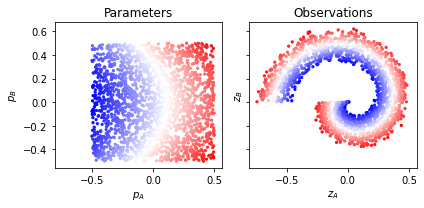

In [4]:
rng = np.random.default_rng(random_seed)

xyz = rng.uniform(low=-.5,high=.5,size=(n_pts,3))
x,y,z = xyz[:,0].reshape(-1,1), xyz[:,1].reshape(-1,1), xyz[:,2].reshape(-1,1)

s1 = sensor1(x,y,3,3)

omega = z[:,0]
peff = s1[:,0]+1*s1[:,1]**2

s2 = sensor2(peff,z[:,0],2,2)


fig,ax=plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True)

ax[0].scatter(*s1[:,[0,1]][idx_plot,:].T, s=m_s,c=peff[idx_plot,], cmap=cmap2)
ax[0].set_title("Parameters")
ax[0].set_xlabel(r"$p_A$")
ax[0].set_ylabel(r"$p_B$")

ax[1].scatter(*s2[idx_plot,:].T, s=m_s,c=peff[idx_plot,], cmap=cmap2)
ax[1].set_title("Observations");
ax[1].set_xlabel(r"$z_A$")
ax[1].set_ylabel(r"$z_B$")

fig.tight_layout()
#fig.savefig("jointly_smooth_idea_x1.png")

9.386546203550504
19.386546203550505


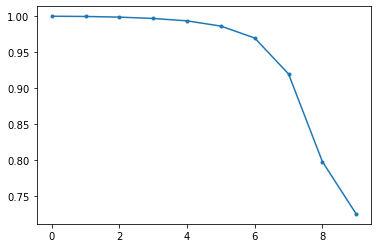

In [5]:
cknn_delta = .8
n_common_evecs = 10
# n_kernel_evecs = 100
kernel_tolerance = 1e-8
eigenvector_tolerance = 1e-10
kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=cknn_k_neighbor, delta=cknn_delta)

jsf = JointlySmoothFunctions(n_kernel_evecs, n_common_evecs, kernel, kernel_tolerance, 
                             evec_tol, backend='scipy.kdtree', cut_off=1e-16,)
jsf.fit(np.column_stack([s1, s2]), ending_points=[s1.shape[1], s1.shape[1]+s2.shape[1]])


plt.plot(jsf.eigenvalues,'.-')
print(jsf.eigenvalues.sum())
print(jsf.calculate_truncated_energies().sum())

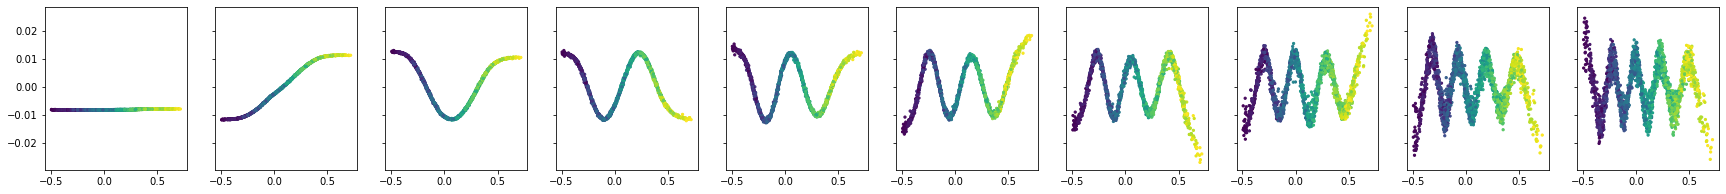

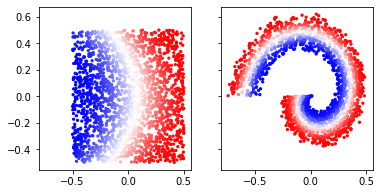

In [6]:
n_plots = 10
fig,ax=plt.subplots(1,n_plots,figsize=(n_plots*3,3),sharey=True)
for k in range(len(ax)):
    ax[k].scatter(peff[idx_plot,].ravel(), jsf.jointly_smooth_functions[idx_plot,k],c=xyz[idx_plot,0], s=5)

fig,ax=plt.subplots(1,2,figsize=(6,3),sharey=True, sharex=True)
ax[0].scatter(*s1[idx_plot,:].T,c=jsf.jointly_smooth_functions[idx_plot,1], s=m_s, cmap=cmap2);
ax[1].scatter(*s2[idx_plot,:].T,c=jsf.jointly_smooth_functions[idx_plot,1], s=m_s, cmap=cmap2);

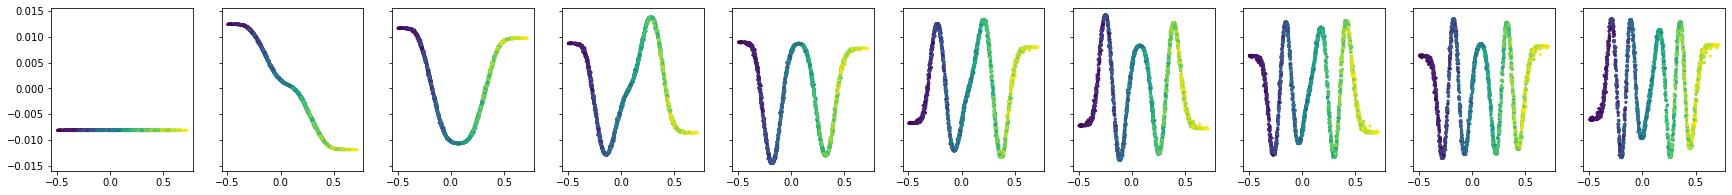

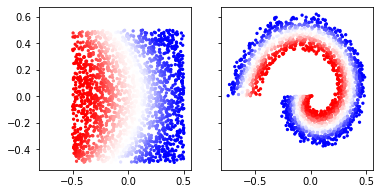

In [7]:
# first span only the common function space
pcm = pfold.PCManifold(jsf.jointly_smooth_functions[:, 1:3])
pcm.optimize_parameters()
kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=cknn_k_neighbor, delta=cknn_delta)
dmap = dfold.DiffusionMaps(n_eigenpairs=n_kernel_evecs, kernel=kernel,
                          dist_kwargs=dict(kmin=cknn_k_neighbor, cut_off=1e-16))
dmap.fit(pcm)

n_plots = 10
fig,ax=plt.subplots(1,n_plots,figsize=(n_plots*3,3),sharey=True)
for k in range(len(ax)):
    ax[k].scatter(peff[idx_plot,].ravel(), dmap.eigenvectors_[idx_plot,k],c=xyz[idx_plot,0], s=5)

fig,ax=plt.subplots(1,2,figsize=(6,3),sharey=True, sharex=True)
ax[0].scatter(*s1[idx_plot,:].T,c=dmap.eigenvectors_[idx_plot,1], s=m_s, cmap=cmap2);
ax[1].scatter(*s2[idx_plot,:].T,c=dmap.eigenvectors_[idx_plot,1], s=m_s, cmap=cmap2);

In [8]:
# now, remove the common functions from the kernel of the right data set
def remove_subspace(full_space, sub_space):
    c = full_space.T @ sub_space
    for k in range(c.shape[0]):
        remove_direction = sub_space @ c[k,:].reshape(-1)
        full_space[:,k] -= remove_direction
    return full_space
fullspace = jsf.kernel_eigenvectors_[1]
subspace = dmap.eigenvectors_

remainingspace = remove_subspace(fullspace, subspace)

print(f"fullspace: {fullspace.shape}, subspace: {subspace.shape}, remainingspace {remainingspace.shape}")

fullspace: (15000, 500), subspace: (15000, 500), remainingspace (15000, 500)


9.997859348650998
19.99785934865058


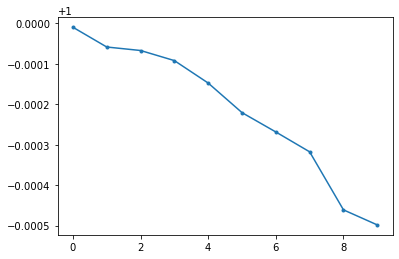

In [9]:
# compute the jointly smooth functions between the remaining and the full space to get a new, smooth basis
# of the uncommon functions
kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=cknn_k_neighbor, delta=cknn_delta)

jsf_uncommon = JointlySmoothFunctions(n_kernel_evecs, n_common_evecs, kernel, kernel_tolerance, 
                             evec_tol, backend='scipy.kdtree', cut_off=1e-16,)

if False:
    # note that this here does NOT work well. 
    # it is better to AGAIN compute the kernels on the remainingspace.
    jsf_uncommon.kernel_eigenvectors_ = [
        jsf.kernel_eigenvectors_[1],
        remainingspace
    ]
    # we do not need to call fit here, since the eigenvectors are all there already
    jointly_smooth_functions_uncommon, eigenvalues_uncommon = jsf_uncommon._calculate_jointly_smooth_functions()

    jsf_uncommon._eigenvalues_ = eigenvalues_uncommon
    jsf_uncommon._jointly_smooth_functions_ = jointly_smooth_functions_uncommon
else:
    jsf_uncommon.fit(np.column_stack([remainingspace, s2]),
                     ending_points=[remainingspace.shape[1], remainingspace.shape[1]+s2.shape[1]])

plt.plot(jsf_uncommon.eigenvalues,'.-')
print(jsf_uncommon.eigenvalues.sum())
print(jsf_uncommon.calculate_truncated_energies().sum())

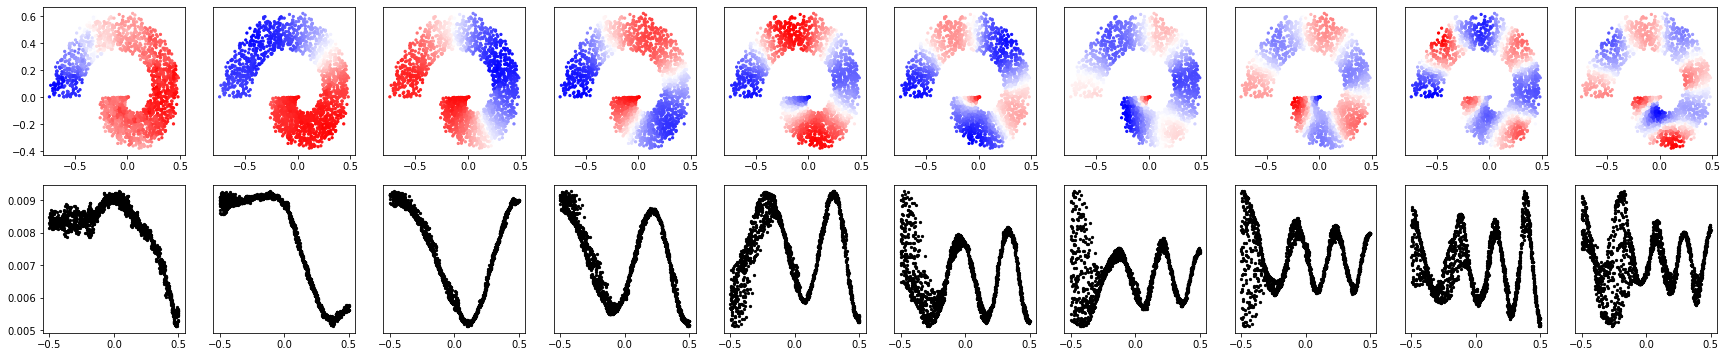

In [10]:
plot_vectors = jsf_uncommon._jointly_smooth_functions_


n_plots = 10
fig,ax=plt.subplots(2,n_plots,figsize=(n_plots*3,6))#,sharey=True)
for k in range(n_plots):
    ax[0, k].scatter(*s2[idx_plot,:].T, c= plot_vectors[idx_plot,k], s=m_s, cmap=cmap2);
    ax[1, k].scatter(z[idx_plot, 0], plot_vectors[idx_plot,k], c='k', s=m_s, cmap=cmap2);
    if k>0:
        ax[0,k].set_yticks([])
        ax[1,k].set_yticks([])

In [11]:
# first span only the common function space
pcm = pfold.PCManifold(jsf_uncommon.jointly_smooth_functions[:, 0:3])
pcm.optimize_parameters()
# kernel = pfold.kernels.ContinuousNNKernel(k_neighbor=cknn_k_neighbor, delta=cknn_delta)
kernel = pcm.kernel
dmap_uncommon = dfold.DiffusionMaps(n_eigenpairs=n_kernel_evecs, kernel=kernel,
                          dist_kwargs=dict( cut_off=pcm.cut_off))
dmap_uncommon.fit(pcm)

DiffusionMaps(dist_kwargs={'cut_off': 0.000789230900549208},
              kernel=GaussianKernel(epsilon=3.3814462290499845e-08),
              n_eigenpairs=500)

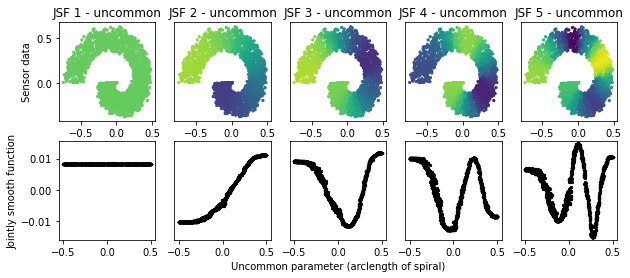

In [49]:

# plot_vectors = jsf_uncommon._jointly_smooth_functions_
plot_vectors = dmap_uncommon.eigenvectors_

n_plots = 5
ylim = np.array([np.min(plot_vectors[:,:n_plots]), np.max(plot_vectors[:,:n_plots])]) * 1.05
fig,ax=plt.subplots(2,n_plots,figsize=(n_plots*2,4))# ,sharey=True)
for k in range(n_plots):
    ax[0, k].scatter(*s2[idx_plot,:].T, c= plot_vectors[idx_plot,k], s=m_s, cmap=cmap1, vmin=ylim[0], vmax=ylim[1]);
    ax[1, k].scatter(z[idx_plot,0], plot_vectors[idx_plot,k], c='k', s=m_s, cmap=cmap1);
    ax[1, k].set_ylim(ylim)
    if k>0:
        ax[0,k].set_yticks([])
        ax[1,k].set_yticks([])
    if k==0:
        ax[1,k].set_ylabel("Jointly smooth function")
        ax[0,k].set_ylabel("Sensor data")
    if k==2:
        ax[1,k].set_xlabel(f"Uncommon parameter (arclength of spiral)")
    ax[0,k].set_title(f"JSF {k+1} - uncommon")
    # ax[1,k].legend()
fig.savefig("toy_jsf_uncommon.pdf")
fig.savefig("toy_jsf_uncommon.png")

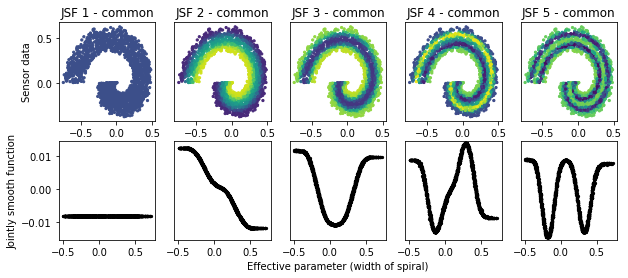

In [48]:

# plot_vectors = jsf_uncommon._jointly_smooth_functions_
plot_vectors = dmap.eigenvectors_

n_plots = 5
ylim = np.array([np.min(plot_vectors[:,:n_plots]), np.max(plot_vectors[:,:n_plots])]) * 1.05
fig,ax=plt.subplots(2,n_plots,figsize=(n_plots*2,4))# ,sharey=True)
for k in range(n_plots):
    ax[0, k].scatter(*s2[idx_plot,:].T, c= plot_vectors[idx_plot,k], s=m_s, cmap=cmap1, vmin=ylim[0], vmax=ylim[1]);
    ax[1, k].scatter(peff[idx_plot], plot_vectors[idx_plot,k], c='k', s=m_s, cmap=cmap1);
    ax[1, k].set_ylim(ylim)
    if k>0:
        ax[0,k].set_yticks([])
        ax[1,k].set_yticks([])
    if k==0:
        ax[1,k].set_ylabel("Jointly smooth function")
        ax[0,k].set_ylabel("Sensor data")
    if k==2:
        ax[1,k].set_xlabel(f"Effective parameter (width of spiral)")
    ax[0,k].set_title(f"JSF {k+1} - common")
    # ax[1,k].legend()
fig.savefig("toy_jsf_common.pdf")
fig.savefig("toy_jsf_common.png")